In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.special as sci
from scipy.integrate import quad


In [11]:
a_ik = [-0.999985,-0.7369246,0.511210,-0.0826998,0.0655341,-0.562082,-0.905911,0.357729,0.358593,0.869386,-0.232996,0.0388327,0.661931,-0.930856,-0.893077,-0.0594001]





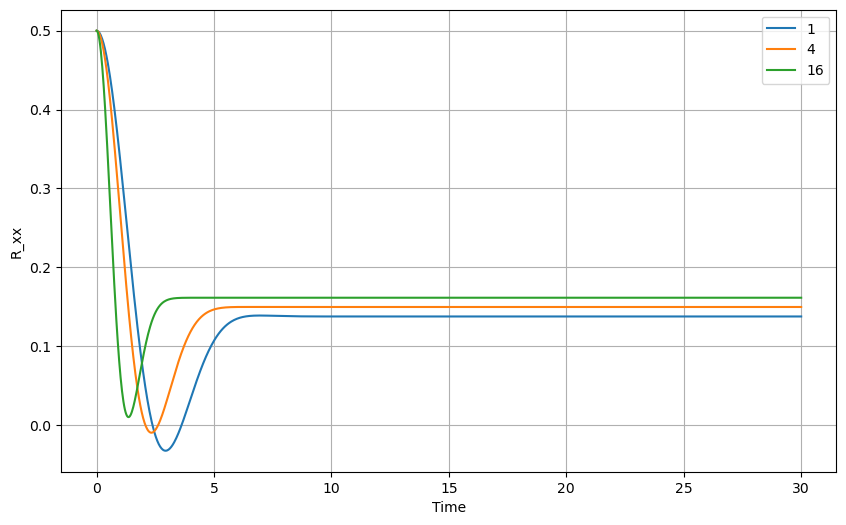

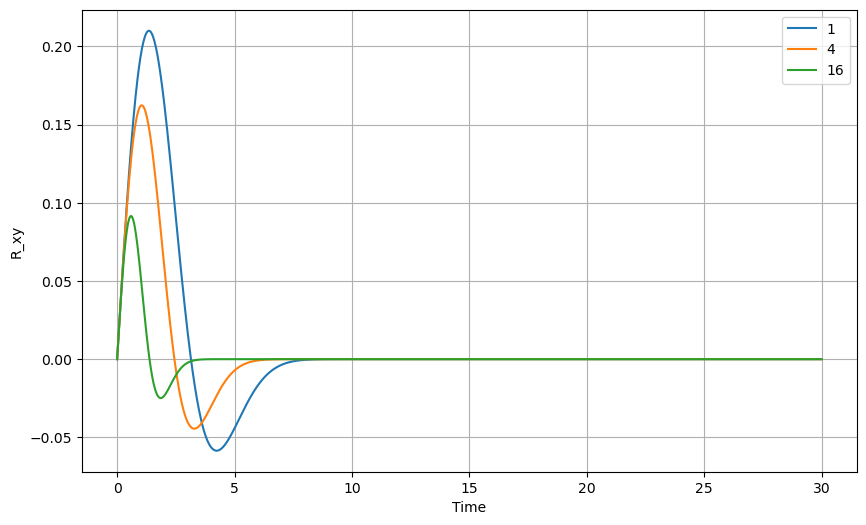

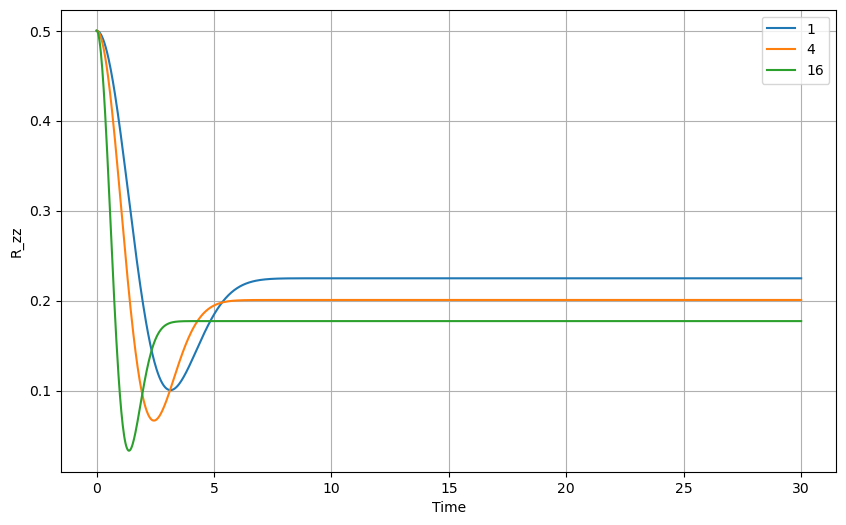

In [12]:
class Schulten_wolynes:


    def __init__(self,applied_magnetic_field_strength,gyromagnetic_ratio,nuclei_number,total_time,time_steps,a_ik):
          self.applied_magnetic_field_strength = applied_magnetic_field_strength
          self.gyromagnetic_ratio = gyromagnetic_ratio
          self.nuclei_number = nuclei_number
          self.total_time = total_time
          self.time_steps = time_steps
          self.a_ik = a_ik


    def calculate_electron_tensor(self,tensor): 
         electron_spin_correlation_tensor = []
         t_star_array = []
         func_w_star_t_star_array = []
         tau = self.__calculate_tau__()
         w_star = self.__calculate_w_star__(tau)
         time_increment = self.total_time / self.time_steps
         
         for i in range(self.time_steps):
              
                current_time = i * time_increment
                t_star = current_time / tau
                func_w_star_t_star = self.__calculate_func_numerically__(t_star,w_star)
              
                tensor_function = getattr(self, tensor)
            
                t_star_array.append(t_star)
                func_w_star_t_star_array.append(func_w_star_t_star)
                electron_spin_correlation_tensor.append(tensor_function(w_star, t_star, func_w_star_t_star))
         
         
         
         return np.real(electron_spin_correlation_tensor)
        
    
    def __integrand__(self,s, w):
        return np.exp(-s**2) * np.sin(w * s)
         
    def __calculate_func_numerically__(self,t_star,w_star):
         func_w_star_t_star_value, error = quad(self.__integrand__, 0 ,t_star, args=(w_star))
         return func_w_star_t_star_value 


    def __calculate_tau__(self):
        a_ik_square = np.square(self.a_ik[0:self.nuclei_number]) # squaring array elements
        sum_a_ik_square = np.sum(a_ik_square) # summing up to nuclei number array elements
        nuclear_constant = 0.5*(0.5 + 1)
        tau_squared = 6 / (sum_a_ik_square*nuclear_constant)
        tau = np.sqrt(tau_squared)
        return  tau


    def __calculate_w_star__(self,tau):
        w_i = -self.gyromagnetic_ratio*self.applied_magnetic_field_strength # Looking at w_i as norm calculation
        w_star = w_i * tau
        return  abs(w_star)
              
    def __R_xx__(self, w_star, t_star, func_w_star_t_star):
        exp_term = np.exp(-t_star ** 2)
        cos_term = np.cos(w_star * t_star)
        sin_term = np.sin(w_star * t_star)
        return (w_star * (2 + np.exp(-t_star**2) * ((w_star**2 - 2) * np.cos(w_star * t_star) - 2 * w_star * t_star * np.sin(w_star * t_star))) - 4 * func_w_star_t_star) / (2 * w_star**3)
        

    def __R_xy__(self,w_star,t_star, func_w_star_t_star):
        exp_term = np.exp(-t_star**2)
        cos_term = np.cos(w_star * t_star)
        sin_term = np.sin(w_star * t_star)
        return exp_term*(2*w_star*t_star*cos_term + (w_star**2 -2)*sin_term) / (2* w_star**2)


    def __R_zz__(self, w_star, t_star, func_w_star_t_star):
        exp_term = np.exp(-t_star ** 2)
        cos_term = np.cos(w_star * t_star)
        sin_term = np.sin(w_star * t_star)
        return (w_star * ((w_star** 2 ) + (4 * exp_term * cos_term) -4) + ( 8 * func_w_star_t_star)) / (2 * (w_star ** 3))
    
       



    



test = Schulten_wolynes(0.5,-1.001,1,30,1000,a_ik) # Use 0.001 for zero magnetic field play around with reducing it further 

R_xx_1 = test.calculate_electron_tensor('__R_xx__')
R_xy_1 = test.calculate_electron_tensor('__R_xy__')
R_zz_1 = test.calculate_electron_tensor('__R_zz__')

test = Schulten_wolynes(0.5,-1.001,4,30,1000,a_ik)

R_xx_4 = test.calculate_electron_tensor('__R_xx__')
R_xy_4 = test.calculate_electron_tensor('__R_xy__')
R_zz_4 = test.calculate_electron_tensor('__R_zz__')

test = Schulten_wolynes(0.5,-1.001,16,30,1000,a_ik)

R_xx_16 = test.calculate_electron_tensor('__R_xx__')
R_xy_16 = test.calculate_electron_tensor('__R_xy__')
R_zz_16 = test.calculate_electron_tensor('__R_zz__')


time_points = np.linspace(0, 30, 1000)


plt.figure(figsize=(10, 6))
plt.plot(time_points, R_xx_1, label='1')
plt.plot(time_points, R_xx_4, label='4')
plt.plot(time_points, R_xx_16, label='16')
plt.xlabel('Time')
plt.ylabel('R_xx')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_xy_1, label='1')
plt.plot(time_points, R_xy_4, label='4')
plt.plot(time_points, R_xy_16, label='16')
plt.xlabel('Time')
plt.ylabel('R_xy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_zz_1, label='1')
plt.plot(time_points, R_zz_4, label='4')
plt.plot(time_points, R_zz_16, label='16')
plt.xlabel('Time')
plt.ylabel('R_zz')
plt.legend()
plt.grid(True)
plt.show()



In [61]:
gyromagnetic_ratio = -1.001
applied_magnetic_field_strength = 0.5
w_i = -gyromagnetic_ratio * applied_magnetic_field_strength
omega_bold_i = [0,0,w_i]


def monte_carlo_integration(total_time,time_steps,nuclei_number):
    Si_t_array, Si_0 = solve_coupled_eq(total_time,time_steps,nuclei_number)
    
    return 


def solve_coupled_eq(total_time,time_steps,nuclei_number):
    current_time = 0
    time_increment = total_time / time_steps
    Si_0 = random_initial_vector()
    Iik_0 = []
    Si_t_array = []
    for i in range(nuclei_number):
        Iik_0.append(random_initial_vector())

    Iik = Iik_0


    while current_time <= total_time:
        S_omega_bold = Si_omega_bold(omega_bold_i,a_ik,Iik,nuclei_number)
        Si_t_current = Si_t(S_omega_bold,Si_0,time_increment/2)
        
        for i in range(nuclei_number):
            I_omega_bold = Iik_omega_bold(a_ik[i],Si_t_current)
            Iik[i] = Iik_t(I_omega_bold,Iik_0[i],time_increment)
        
        S_omega_bold = Si_omega_bold(omega_bold_i,a_ik,Iik,nuclei_number)
        Si_t_current = Si_t(S_omega_bold,Si_0,time_increment/2)

        Si_t_array.append(Si_t_current)
        current_time += time_increment

    return Si_t_array, Si_0 

def Si_t(omega_bold,Si_0,t):
    omega = np.linalg.norm(omega_bold)
    omega_hat = omega_bold / omega 
    
    Si_parallel = np.dot(omega_hat,omega_hat) * Si_0
    Si_perpendicular = [1-np.dot(omega_hat,omega_hat)] * Si_0
    Si_cross = np.cross(omega_hat,Si_0)
    Si_t = Si_parallel + Si_perpendicular*np.cos(omega*t) + Si_cross*np.sin(omega*t)
    return Si_t

def Iik_t(omega_bold,Iik_0,t):
    omega = np.linalg.norm(omega_bold)
    omega_hat = omega_bold / omega 
    
    Iik_t_parallel = np.dot(omega_hat,omega_hat)*Iik_0
    Iik_t_perpendicular = [1-np.dot(omega_hat,omega_hat)]*Iik_0
    Iik_t_cross = np.cross(omega_hat,Iik_0)
    Iik = Iik_t_parallel + Iik_t_perpendicular*np.cos(omega*t) + Iik_t_cross*np.sin(omega*t)
    return Iik

def Si_omega_bold(omega_bold_i,a_ik,Iik,nuclei_number):
    aik_Iik = []
    Iik = np.array(Iik)
    for i in range(nuclei_number): #summation of a_ik and Iik 
        temp_aik_Iik = a_ik[i]*Iik[i]
        aik_Iik.append(temp_aik_Iik)

    sum_aik_Iik = sum(aik_Iik)
    omega_bold = omega_bold_i + sum_aik_Iik
    return omega_bold

def Iik_omega_bold(a_ik,Si):
    omega_bold = a_ik * Si 
    return omega_bold

def random_initial_vector():
    theta = np.pi * np.random.uniform(0, 1)  # 0 to pi
    phi = 2 * np.pi * np.random.uniform(0, 1)  # 0 to 2pi
    sqrt_0_75 = np.sqrt(0.75)
    vector = [
        sqrt_0_75 * np.cos(phi) * np.sin(theta),
        sqrt_0_75 * np.sin(phi) * np.sin(theta),
        sqrt_0_75 * np.cos(theta)
    ]
    return np.array(vector)



Si_t_array = solve_coupled_eq(30,1000,4)


[array([-0.44373884,  0.09782576, -0.73731587]), array([-0.4435889 ,  0.09782282, -0.73740439]), array([-0.44343762,  0.09782204, -0.73749339]), array([-0.44328509,  0.09782341, -0.73758283]), array([-0.44313135,  0.09782691, -0.73767268]), array([-0.44297647,  0.09783254, -0.73776291]), array([-0.44282051,  0.09784026, -0.73785348]), array([-0.44266354,  0.09785007, -0.73794436]), array([-0.44250561,  0.09786195, -0.73803551]), array([-0.44234679,  0.09787587, -0.73812691]), array([-0.44218713,  0.09789182, -0.73821851]), array([-0.4420267 ,  0.09790977, -0.73831029]), array([-0.44186556,  0.0979297 , -0.73840221]), array([-0.44170377,  0.09795158, -0.73849424]), array([-0.44154138,  0.09797539, -0.73858635]), array([-0.44137846,  0.0980011 , -0.73867852]), array([-0.44121506,  0.09802868, -0.7387707 ]), array([-0.44105125,  0.09805811, -0.73886288]), array([-0.44088707,  0.09808935, -0.73895501]), array([-0.44072258,  0.09812238, -0.73904708]), array([-0.44055785,  0.09815715, -0.739

[array([-0.44373884,  0.09782576, -0.73731587]), array([-0.4435889 ,  0.09782282, -0.73740439]), array([-0.44343762,  0.09782204, -0.73749339]), array([-0.44328509,  0.09782341, -0.73758283]), array([-0.44313135,  0.09782691, -0.73767268]), array([-0.44297647,  0.09783254, -0.73776291]), array([-0.44282051,  0.09784026, -0.73785348]), array([-0.44266354,  0.09785007, -0.73794436]), array([-0.44250561,  0.09786195, -0.73803551]), array([-0.44234679,  0.09787587, -0.73812691]), array([-0.44218713,  0.09789182, -0.73821851]), array([-0.4420267 ,  0.09790977, -0.73831029]), array([-0.44186556,  0.0979297 , -0.73840221]), array([-0.44170377,  0.09795158, -0.73849424]), array([-0.44154138,  0.09797539, -0.73858635]), array([-0.44137846,  0.0980011 , -0.73867852]), array([-0.44121506,  0.09802868, -0.7387707 ]), array([-0.44105125,  0.09805811, -0.73886288]), array([-0.44088707,  0.09808935, -0.73895501]), array([-0.44072258,  0.09812238, -0.73904708]), array([-0.44055785,  0.09815715, -0.739

1000